# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работы:
- проанализируем данные, сделаем предобработку, если понадобится;
- подготовим данные для обучения;
- обучим и сравним несколько моделей;
- выберем лучшую и протестируем ее

## Подготовка данных

### Знакомство с данными, предобработка

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as ltb

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/autos.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
display(data.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных есть пропуски, некоторые из которых критичны для обучения, например в столбце Model. Также требуется преобразование типов данных в столбце с датой и некоторых других.
Для обучения нужны не все из имеющихся признаков. Начнем с того, что отбросим лишние.

In [4]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


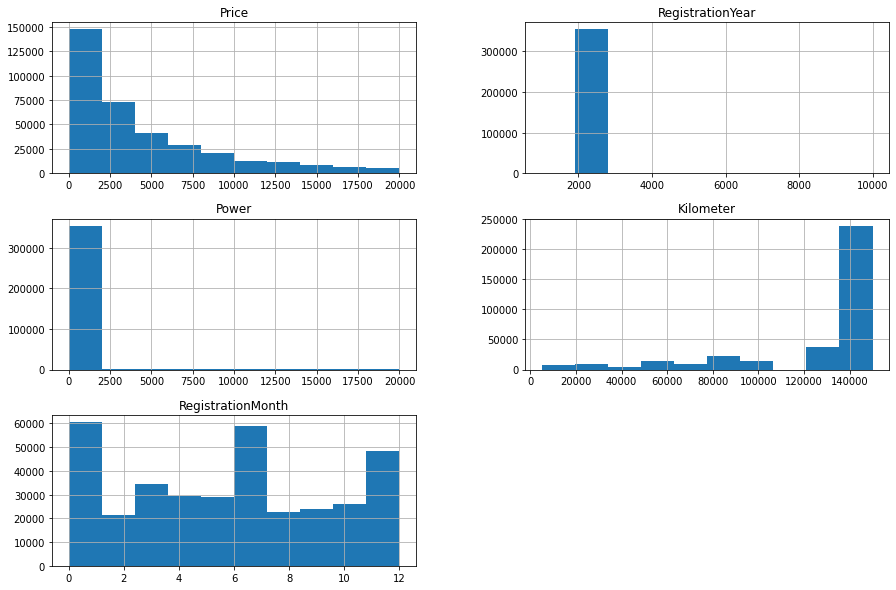

In [5]:
display(data.describe())
data.hist(figsize=(15, 10));

В некоторых признаках также есть аномалии, требующие обработки. Например, Price = 0 или RegistrationYear = 9999, Power = 20000, все это явно некорректные данные.

In [6]:
#удаляем объекты с пропусками в признаке Model, т.к. они критичны для обучения и не восстановимы
data = data.dropna(subset=['Model'])

display(data.loc[data['VehicleType'].isna() == True])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05 00:00:00
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00


In [7]:
#пропуски в признаке VehicleType можно восстановить, подтянув данные от объектов
#аналогичной модели, если у одинаковых моделей авто VehicleType будет одинаковым
display(data.groupby(['Brand', 'Model', 'VehicleType'])['Price'].count())

Brand       Model     VehicleType
alfa_romeo  145       coupe            2
                      other            1
                      sedan           13
                      small           19
            147       coupe           27
                                    ... 
volvo       v70       coupe            1
                      wagon          608
            xc_reihe  sedan            3
                      suv            216
                      wagon           41
Name: Price, Length: 1411, dtype: int64

Идея не оправдалась, т.к. у одних и тех же моделей встречается несколько типов кузова.

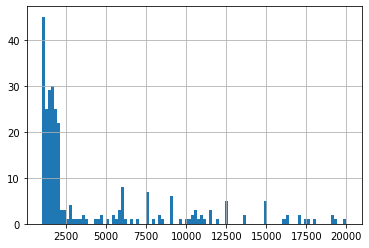

In [8]:
#проанализируем выбросы в признаке Power
data['Power'].hist(range = (1000, 20000), bins=100);

In [9]:
data.query('Power > 1000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00
9664,2016-03-14 20:06:19,2599,NaN,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,NaN,2016-03-13 00:00:00
348968,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04 00:00:00
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07 00:00:00
353493,2016-04-02 20:54:21,12500,NaN,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02 00:00:00


In [10]:
data.query('Power > 1000')['Brand'].unique()

array(['toyota', 'opel', 'volkswagen', 'ford', 'fiat', 'seat', 'bmw',
       'nissan', 'mercedes_benz', 'citroen', 'volvo', 'chevrolet',
       'peugeot', 'smart', 'kia', 'audi', 'renault', 'chrysler', 'mazda',
       'suzuki', 'skoda', 'mini', 'alfa_romeo', 'mitsubishi', 'daewoo',
       'lancia'], dtype=object)

Нашлось 265 машин с мощностью больше 1000 л.с. и ни одна из них не Бугатти Вейрон. Удаляю из датасета эти объекты.

In [11]:
data = data.query('Power < 1000')

<AxesSubplot:>

<AxesSubplot:>

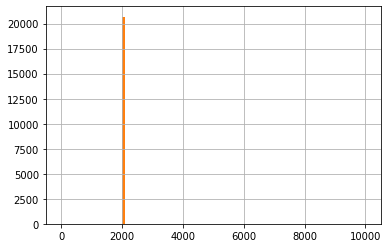

In [12]:
display(data['RegistrationYear'].hist(range = (0, 1900), bins=100));
display(data['RegistrationYear'].hist(range = (2016, 9999), bins=100));

In [13]:
display(data.query('RegistrationYear < 1900').head(5))
display(data.query('RegistrationYear > 2016').head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00
53577,2016-03-20 11:44:28,330,NaN,1000,NaN,0,polo,5000,0,NaN,volkswagen,NaN,2016-03-20 00:00:00
67167,2016-04-01 08:55:24,0,NaN,1500,NaN,0,kuga,5000,7,gasoline,ford,NaN,2016-04-01 00:00:00
71459,2016-03-27 23:46:28,500,NaN,1000,NaN,0,golf,5000,0,NaN,volkswagen,NaN,2016-03-27 00:00:00


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00


Есть небольшое количество объектов с RegistrationYear меньше 1900 и больше 2016 (год выгрузки датасета) - удаляю их, т.к. у этих объектов есть проблемы и в других признаках - пропуски, либо некорректные значения.

In [14]:
data = data.query('RegistrationYear > 1900')
data = data.query('RegistrationYear < 2016')

In [15]:
data.query('Price == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22 00:00:00
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,NaN,ford,NaN,2016-03-16 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00


In [16]:
#удаляю объекты с нулевой ценой, т.к. они будут только ухудшать качество обучения
data = data.query('Price != 0')

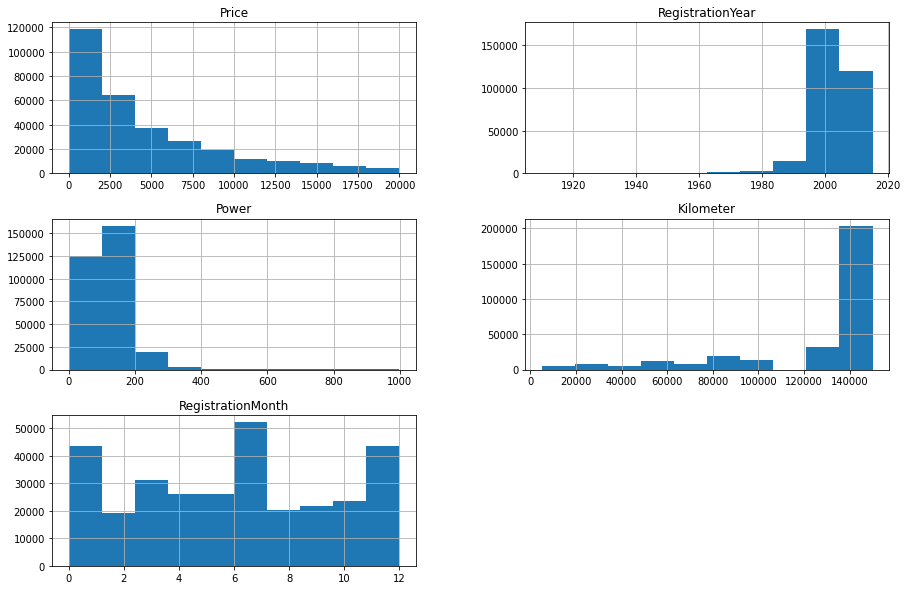

In [17]:
data.hist(figsize=(15, 10));

In [18]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d %H:%M:%S')

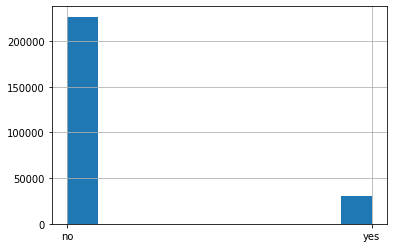

In [19]:
data['NotRepaired'].hist();

In [20]:
#с учетом распределения данных в столбце NotRepaired предположим, что в пропусках забыли указать 'no'
data['NotRepaired'] = data['NotRepaired'].fillna('no')

#оставшиеся пропуски удалим
data = data.dropna(subset=['VehicleType', 'Gearbox', 'FuelType'])

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278740 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278740 non-null  datetime64[ns]
 1   Price              278740 non-null  int64         
 2   VehicleType        278740 non-null  object        
 3   RegistrationYear   278740 non-null  int64         
 4   Gearbox            278740 non-null  object        
 5   Power              278740 non-null  int64         
 6   Model              278740 non-null  object        
 7   Kilometer          278740 non-null  int64         
 8   RegistrationMonth  278740 non-null  int64         
 9   FuelType           278740 non-null  object        
 10  Brand              278740 non-null  object        
 11  NotRepaired        278740 non-null  object        
 12  DateCreated        278740 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(6)
me

### Разделение на тренировочную, валидационную и тестовую выборки

In [22]:
features = data.drop(['DateCrawled', 'Price', 'DateCreated'], axis=1)
target = data['Price']

features_train, features_vt, target_train, target_vt = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_vt, target_vt, test_size=0.5, random_state=12345)

## Обучение моделей

### DecisionTree

In [23]:
#кодировка категориальных признаков техникой OrdinalEncoder
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

features_train_ordinal = features_train
features_valid_ordinal = features_valid
features_test_ordinal = features_test

encoder = OrdinalEncoder()
encoder.fit(data[category])

features_train_ordinal[category] = encoder.transform(features_train[category])
features_valid_ordinal[category] = encoder.transform(features_valid[category])
features_test_ordinal[category] = encoder.transform(features_test[category])

#display(features_train_ordinal.head(5))

/tmp/ipykernel_230/235661845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ordinal[category] = encoder.transform(features_train[category])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_230/235661845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [24]:
%%time
#начнем с простой деревянной модели

best_result = 20000
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train_ordinal, target_train)
    predictions_valid = model.predict(features_valid_ordinal)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_result = result
        best_depth = depth

print('RMSE:', round(best_result))
print('best_depth:', best_depth)

RMSE: 1949
best_depth: 10
CPU times: user 2.2 s, sys: 0 ns, total: 2.2 s
Wall time: 2.2 s


Выяснили лучшую глубину - 10, теперь сделаем замеры времени обучения и предсказания

In [25]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=10)
model.fit(features_train_ordinal, target_train)

CPU times: user 370 ms, sys: 147 µs, total: 370 ms
Wall time: 374 ms


DecisionTreeRegressor(max_depth=10, random_state=12345)

In [26]:
%%time

predictions_valid = model.predict(features_valid_ordinal)
rmse_tree = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE:', round(rmse_tree))

RMSE: 1949
CPU times: user 6.85 ms, sys: 3.89 ms, total: 10.7 ms
Wall time: 9.26 ms


По условию задачи RMSE должно быть меньше 2500 - с этим справилась даже простенькая модель DecisionTree, значит задачу можно считать выполненной.
Теперь попробуем минимизировать RMSE с помощью других моделей, в т.ч. градиентным бустингом.

### RandomForest

In [27]:
%%time

model = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=10)
model.fit(features_train_ordinal, target_train)

CPU times: user 12.2 s, sys: 11.1 ms, total: 12.2 s
Wall time: 12.2 s


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)

In [28]:
%%time

predictions_valid = model.predict(features_valid_ordinal)
rmse_forest = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE:', round(rmse_forest))

RMSE: 1833
CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 250 ms


У модели леса со случайно выбранными гиперпараметрами RMSE еще лучше.

### CatBoost

In [29]:
%%time

model = CatBoostRegressor(iterations=200)
model.fit(features_train, target_train)

Learning rate set to 0.340198
0:	learn: 3614.6813435	total: 76ms	remaining: 15.1s
1:	learn: 3000.1164905	total: 100ms	remaining: 9.92s
2:	learn: 2635.0695891	total: 126ms	remaining: 8.28s
3:	learn: 2411.5984550	total: 150ms	remaining: 7.34s
4:	learn: 2273.6725683	total: 174ms	remaining: 6.77s
5:	learn: 2176.9157927	total: 197ms	remaining: 6.38s
6:	learn: 2114.9773658	total: 222ms	remaining: 6.11s
7:	learn: 2074.4094146	total: 245ms	remaining: 5.88s
8:	learn: 2041.4879424	total: 267ms	remaining: 5.67s
9:	learn: 2007.3589969	total: 291ms	remaining: 5.52s
10:	learn: 1965.1449573	total: 314ms	remaining: 5.4s
11:	learn: 1948.3458161	total: 335ms	remaining: 5.25s
12:	learn: 1918.3205653	total: 358ms	remaining: 5.15s
13:	learn: 1908.4190850	total: 379ms	remaining: 5.04s
14:	learn: 1894.5817010	total: 400ms	remaining: 4.94s
15:	learn: 1878.3293938	total: 424ms	remaining: 4.88s
16:	learn: 1867.0619249	total: 446ms	remaining: 4.8s
17:	learn: 1858.1980912	total: 468ms	remaining: 4.74s
18:	learn: 

In [30]:
%%time

predictions_valid = model.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE:', round(rmse_cat))

RMSE: 1594
CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 17.7 ms


Модель показывает лучший результат из имеющихся, и наивысшую скорость обучения! Также модель отлично справилась с незакодированными категориальными признаками - пользоваться ей проще, чем традиционными моделями.

### LightGBM

In [31]:
%%time

model = ltb.LGBMRegressor()
model.fit(features_train_ordinal, target_train)

CPU times: user 5.11 s, sys: 8.65 ms, total: 5.12 s
Wall time: 5.05 s


LGBMRegressor()

In [32]:
%%time

predictions_valid = model.predict(features_valid_ordinal)
rmse_lgbm = mean_squared_error(target_valid, predictions_valid) ** 0.5

print('RMSE:', round(rmse_lgbm))

RMSE: 1653
CPU times: user 530 ms, sys: 3.61 ms, total: 534 ms
Wall time: 591 ms


Модель показывает высокий, хотя и немного более скромный результат, чем CatBoost, но и скорость ее работы почти в 2 раза выше.

### LinearRegression

In [33]:
#кодировка категориальных признаков методом OHE

features_train_ohe = features_train
features_valid_ohe = features_valid
features_test_ohe = features_test

features_train_ohe[category] = pd.get_dummies(features_train_ohe[category], drop_first=True)
features_valid_ohe[category] = pd.get_dummies(features_valid_ohe[category], drop_first=True)
features_test_ohe[category] = pd.get_dummies(features_test_ohe[category], drop_first=True)

#масштабирование количественных признаков
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/tmp/ipykernel_230/1430665140.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [34]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: user 44.1 ms, sys: 20.2 ms, total: 64.3 ms
Wall time: 64.8 ms


LinearRegression()

In [35]:
%%time

predictions_valid = model.predict(features_valid_ohe)
rmse_linear = mean_squared_error(target_valid, predictions_valid) ** 0.5

pd.options.mode.chained_assignment = None

print('RMSE:', round(rmse_linear))

RMSE: 2977
CPU times: user 27.4 ms, sys: 51.8 ms, total: 79.1 ms
Wall time: 92.2 ms


## Анализ моделей

In [36]:
models_comp = pd.DataFrame({'model': ['DecisionTree', 'RandomForest', 'LinearRegression', 'CatBoost', 'LightGBM'],
              'RMSE': [round(rmse_tree), round(rmse_forest), round(rmse_linear), round(rmse_cat), round(rmse_lgbm)],
              'learning time, ms': [375, 12400, 64.8, 5290, 3640],
              'prediction time, ms': [9.16, 255, 92.2, 17.7, 504]})
display(models_comp)

,model,RMSE,"learning time, ms","prediction time, ms"
0,DecisionTree,1949,375,9.16
1,RandomForest,1833,12400,255.00
2,LinearRegression,2977,33,6.57
3,CatBoost,1594,5290,17.70
4,LightGBM,1653,3640,504.00


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


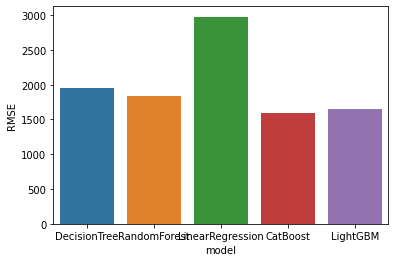

In [37]:
sns.barplot(models_comp['model'], models_comp['RMSE']);

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


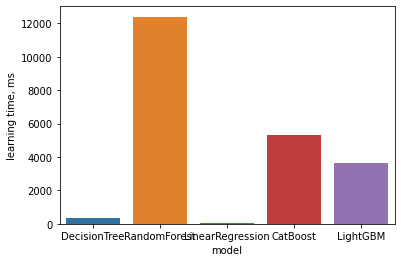

In [38]:
sns.barplot(models_comp['model'], models_comp['learning time, ms']);

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


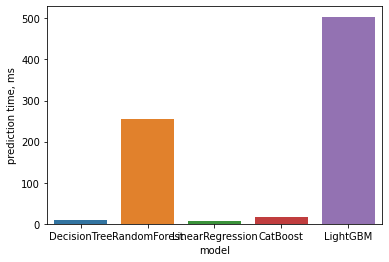

In [39]:
sns.barplot(models_comp['model'], models_comp['prediction time, ms']);

### Тест лучшей модели

In [40]:
model = CatBoostRegressor(iterations=60)
model.fit(features_train_ordinal, target_train)
predictions_test = model.predict(features_test_ordinal)
result = mean_squared_error(target_test, predictions_test) ** 0.5

print('RMSE:', round(result))

Learning rate set to 0.5
0:	learn: 3212.8238411	total: 27.9ms	remaining: 1.65s
1:	learn: 2601.3877847	total: 50.5ms	remaining: 1.47s
2:	learn: 2324.1465278	total: 71.9ms	remaining: 1.36s
3:	learn: 2201.0366907	total: 92.7ms	remaining: 1.3s
4:	learn: 2103.5467470	total: 114ms	remaining: 1.25s
5:	learn: 2047.7621717	total: 136ms	remaining: 1.22s
6:	learn: 2015.9388704	total: 158ms	remaining: 1.2s
7:	learn: 1967.0594556	total: 183ms	remaining: 1.19s
8:	learn: 1929.3958206	total: 205ms	remaining: 1.16s
9:	learn: 1911.6441097	total: 227ms	remaining: 1.14s
10:	learn: 1893.7382097	total: 248ms	remaining: 1.1s
11:	learn: 1871.9421599	total: 271ms	remaining: 1.08s
12:	learn: 1861.1916222	total: 293ms	remaining: 1.06s
13:	learn: 1849.2391089	total: 314ms	remaining: 1.03s
14:	learn: 1837.7595973	total: 337ms	remaining: 1.01s
15:	learn: 1821.2593777	total: 360ms	remaining: 990ms
16:	learn: 1811.1054876	total: 383ms	remaining: 969ms
17:	learn: 1806.2419079	total: 403ms	remaining: 941ms
18:	learn: 1

## Вывод

После предобработки данных было протестировано 5 моделей машинного обучения:
- DecisionTree
- RandomForest
- LinearRegression
- CatBoost
- LightGBM

В данной конкретной задаче у моделей градиентного бустинга наилучшие показатели метрики качества RMSE, лидирует CatBoost, с небольшим отрывом от нее отстает LightGBM. По времени обучения лидируют простые модели - случайный лес и линейная регрессия, самая медленная модель случайного леса. 

Более простые модели хотя и работают достаточно быстро, но результат дают значительно хуже, чем модели, построенные на градиентном бустинге.

Наименее предпочтительной выглядит модель линейной регрессии - она хотя и работает быстрее других, выдает наименьший результат метрики качества. К тому же, для работы модели необходима дополнительная работа по кодированию и масштабированию признаков, что усложняет пользование ею.

С учетом лучшего значения метрики и одного из лучших времен обучения / предсказания рекомендую использовать в этой задаче модель CatBoost. Немаловажно, что для этой модели нет необходимости кодировать категориальные признаки, что упрощает работу с моделью.